# Time-Series Forecasting | Corporación Favorita Grocery Sales
## Section 2: Exploratory Data Analysis
### 1 - Notebook Overview

The goal of this notebook is to conduct an exploratory analysis of the **Pichincha** sample dataset extracted in [Section 1: Data Preparation](/notebooks/01-data-preparation.ipynb) and uncover the underlying patterns of grocery sales in Ecuador. Specifically, this notebook will:

- **Trend & Seasonality Visualization:** Using total sales line plots and Year-Month heatmaps to identify growth trends, December peaks, and period-specific anomalies.
- **Holiday & Event Impact:** Quantifying the "lift" or "suppression" of demand by merging the holiday calendar and analyzing average sales by day-type.
- **Perishability & Category Dynamics:** Segmenting sales between perishable and non-perishable items to assess volume shares and waste risk—a critical factor for forecast accuracy.
- **Time-Series Diagnostics:**
  - **Autocorrelation:** Identifying how past sales influence future values to inform "lag" feature selection.
  - **Stationarity:** Testing the data's statistical properties to determine if differencing is required for modeling.

By the end of this analysis, we will have a "signal-ready" dataset and a clear understanding of the external factors (holidays, oil prices) that must be incorporated into the forecasting models in Section 3.

### 2 - Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# File handling
import os

### 3 - Data Ingestion

In [2]:
# Define local paths to data files
holidays_path = "../data/holidays_events.csv"
items_path = "../data/items.csv"
oil_path = "../data/oil.csv"
stores_path = "../data/stores.csv"
train_path = "../data/train_sample.pkl"
transactions_path = "../data/transactions.csv"

# List of all paths to verify
required_paths = [
    holidays_path, 
    items_path, 
    oil_path, 
    stores_path, 
    train_path,
    transactions_path
]

# Create a list to track any missing files
missing_files = []

for path in required_paths:
    if not os.path.exists(path):
        missing_files.append(path)

if missing_files:
    print("❌ ERROR: Required data files not found in the /data/ folder.")
    print("-" * 50)
    for f in missing_files:
        print(f"Missing: {f}")
    print("-" * 50)
    print("To run this notebook, ensure you have run the Data Preparation notebook")
    print("and placed the Kaggle CSVs in your './data/' directory.")
    print("Link: https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting")
    print("-" * 50)
else:
    print("✅ All required data files detected. Ready to load.")

    # Load datasets
    df_holidays = pd.read_csv(holidays_path)
    df_items = pd.read_csv(items_path)
    df_oil = pd.read_csv(oil_path)
    df_stores = pd.read_csv(stores_path)
    df_train = pd.read_pickle(train_path)
    df_transactions = pd.read_csv(transactions_path)

✅ All required data files detected. Ready to load.


In [3]:
# List of dataframe names
df_names = [
    "df_holidays", 
    "df_items", 
    "df_oil", 
    "df_stores", 
    "df_train", 
    "df_transactions"
]

# Helper function to do a sanity check
def sanity_check(df_names):
    print("SANITY CHECK")
    print("=" * 50)
    for name in df_names:
        if name in globals():
            df = globals()[name]
            print(f"--- {name.upper()} ---")
            # Check shape
            print(f"Shape: {df.shape}")
            # Check memory usage
            memory_gb = df.memory_usage(deep=True).sum() / (1024**3)
            print(f"Memory: {memory_gb:.2f} GB")
            print("\nColumn Data Types:")
            print(df.dtypes)
            # Display first 3 rows
            print("\nPreview:")
            display(df.head(3))
            print("-" * 50)
        else:
            print(f"⚠️ Warning: {name} not found in global namespace.\n")

# Run it
sanity_check(df_names)

SANITY CHECK
--- DF_HOLIDAYS ---
Shape: (350, 6)
Memory: 0.00 GB

Column Data Types:
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

Preview:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


--------------------------------------------------
--- DF_ITEMS ---
Shape: (4100, 4)
Memory: 0.00 GB

Column Data Types:
item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object

Preview:


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0


--------------------------------------------------
--- DF_OIL ---
Shape: (1218, 2)
Memory: 0.00 GB

Column Data Types:
date           object
dcoilwtico    float64
dtype: object

Preview:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


--------------------------------------------------
--- DF_STORES ---
Shape: (54, 5)
Memory: 0.00 GB

Column Data Types:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

Preview:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


--------------------------------------------------
--- DF_TRAIN ---
Shape: (68537168, 11)
Memory: 6.38 GB

Column Data Types:
date                 datetime64[ns]
id                            int64
store_nbr                     int64
item_nbr                      int64
unit_sales                  float64
onpromotion                  object
year                          int32
month                         int32
day                           int32
day_of_week                   int32
unit_sales_7d_avg           float64
dtype: object

Preview:


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-05-09,5329375,1,96995,1.0,False,2013,5,9,3,1.000000
1,2013-05-10,0,1,96995,0.0,0,2013,5,10,4,0.500000
2,2013-05-11,0,1,96995,0.0,0,2013,5,11,5,0.333333


--------------------------------------------------
--- DF_TRANSACTIONS ---
Shape: (83488, 3)
Memory: 0.01 GB

Column Data Types:
date            object
store_nbr        int64
transactions     int64
dtype: object

Preview:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


--------------------------------------------------


### 4 - Data Validation

#### 4.1 Confirming Data Types

In [4]:
# Confirm date columns are in datetime format
df_holidays['date']     = pd.to_datetime(df_holidays['date'])
df_oil['date']          = pd.to_datetime(df_oil['date'])
df_train['date']        = pd.to_datetime(df_train['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

# Convert integer columns to int32 for alignment and to save memory
df_items[['item_nbr', 'class']] = df_items[['item_nbr', 'class']].astype('int32')
df_stores[['store_nbr', 'cluster']] = df_stores[['store_nbr', 'cluster']].astype('int32')
df_train[['id', 'store_nbr', 'item_nbr']] = df_train[['id', 'store_nbr', 'item_nbr']].astype('int32')
df_transactions[['store_nbr', 'transactions']] = df_transactions[['store_nbr', 'transactions']].astype('int32')

# Convert 'onpromotion' column to boolean
df_items['perishable'] = df_items['perishable'].astype(bool)
df_train['onpromotion'] = df_train['onpromotion'].astype(bool)

#### 4.2 Checking for Missing Data

In [5]:
# Helper function to check missing data
def check_missing(df_names):
    print("MISSING VALUES REPORT")
    print("=" * 50)
    for name in df_names:
        if name in globals():
            df = globals()[name]
            print(f"--- {name.upper()} ---")
            display(df.isnull().sum())
            print("-" * 50)
        else:
            print(f"⚠️ Warning: {name} not found in global namespace.\n")

# Run it
check_missing(df_names)

MISSING VALUES REPORT
--- DF_HOLIDAYS ---


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

--------------------------------------------------
--- DF_ITEMS ---


item_nbr      0
family        0
class         0
perishable    0
dtype: int64

--------------------------------------------------
--- DF_OIL ---


date           0
dcoilwtico    43
dtype: int64

--------------------------------------------------
--- DF_STORES ---


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

--------------------------------------------------
--- DF_TRAIN ---


date                 0
id                   0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion          0
year                 0
month                0
day                  0
day_of_week          0
unit_sales_7d_avg    0
dtype: int64

--------------------------------------------------
--- DF_TRANSACTIONS ---


date            0
store_nbr       0
transactions    0
dtype: int64

--------------------------------------------------


The `df_oil` dataset contains **43 missing values** in the `dcoilwtico` column (presumably due to weekends and holidays). While handling these is outside the current scope of this exercise, in a production environment, these should be addressed using `.ffill()` and `.bfill()` to maintain a continuous price signal without changing the column’s numerical data type.

### 5 - Visualizing Time-Series Data

In [6]:
# Consistent color palette
coolwarm_hex = sns.color_palette("coolwarm", as_cmap=False).as_hex()

# Assign short-hand variables for easier access
color_cold = coolwarm_hex[0]
color_hot = coolwarm_hex[-1]

print(f"Seaborn 'coolwarm' palette hex codes:\n{coolwarm_hex}")
coolwarm_hex

Seaborn 'coolwarm' palette hex codes:
['#6788ee', '#9abbff', '#c9d7f0', '#edd1c2', '#f7a889', '#e26952']


['#6788ee', '#9abbff', '#c9d7f0', '#edd1c2', '#f7a889', '#e26952']

### 5.1 Temporal Sales Trend: Pichincha Region (2013-2017)

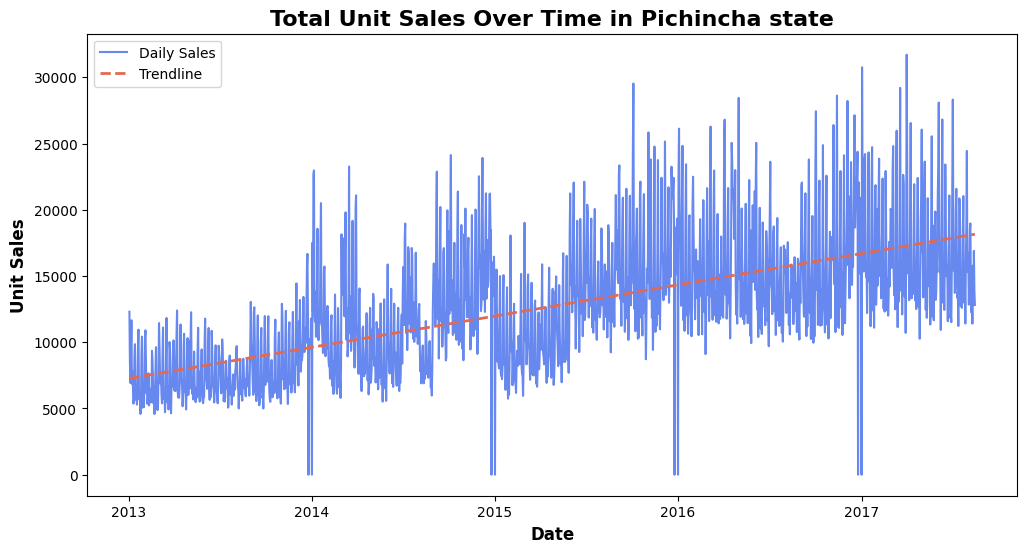

In [7]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Convert dates to numerical format for plotting
x_data = mdates.date2num(sales_by_date.index)
y_data = sales_by_date.values

# Calculate the trendline (linear regression)
z = np.polyfit(x_data, y_data, 1)
p = np.poly1d(z)

# Setting up the plot
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date.index, sales_by_date.values, color=color_cold, alpha=1, label='Daily Sales')
plt.plot(sales_by_date.index, p(x_data), color=color_hot, linestyle='--', linewidth=2, label='Trendline')

# Add titles, labels, and legend
plt.title('Total Unit Sales Over Time in Pichincha state', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Unit Sales', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save the figure
plt.savefig('../visualizations/pichincha_sales_trend.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Observing total unit sales over time in the Pichincha state, I noticed the following:

- **Steady Growth:** There is a clear upward trend with sales consistently sloping upwards. This shows the business is expanding, and I can look closer at this growth later to see if it’s driven by new store openings or just higher customer demand.
- **Planned Closures:** The sudden drops to near-zero every year likely indicate days when stores are closed for holidays. I’ll need to account for these as "expected zeros" in my forecasting models so the AI doesn't get confused by these artificial dips.
- **Predictable Cycles:** I can see a "heartbeat" in the data from weekly shopping cycles, along with a massive spike every year during Q4. Knowing that the end of the year is always the busiest will be key for helping the business optimize their staffing and stock levels.

### 5.2 Seasonality Analysis: Pichincha Region (2013-2017)

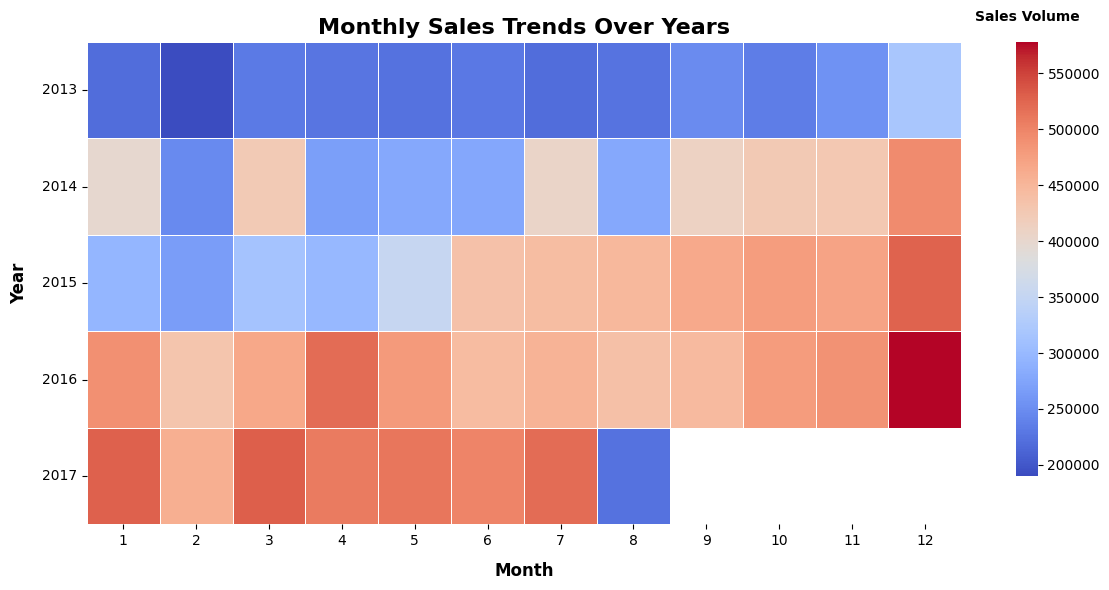

In [8]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Setting up the heatmap of sales by month and year
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    sales_by_month, 
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"anchor": (0, 1.0), "shrink": 0.9}
)

# Add titles and labels
plt.title('Monthly Sales Trends Over Years', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Year', fontsize=12, fontweight='bold', labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)

# Colorbar customization
cbar = ax.collections[0].colorbar
cbar.ax.set_title('Sales Volume', fontweight='bold', fontsize=10, pad=15)
cbar.ax.tick_params(labelsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/pichincha_seasonality_analysis.png', dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

By looking at the sales data as a heatmap, I can really see the "rhythm" of the business and how it changes throughout the year:

- **The December Peak:** It is obvious that December is the "hottest" month every single year, which makes sense since that’s when everyone is out shopping for the holidays. With this insight, inventory, staff and promotions can be increased over this period.
- **The Post-Holiday Slump:** Right after that December rush, sales noticeably cool down in January and February. It looks like people really tighten their belts and spend less at the start of the year after their big holiday splurges.
- **Yearly Progress:** Looking from top to bottom (2013 to 2017), the map gets "warmer" overall. This confirms what I saw in the line chart: the business is definitely getting bigger and busier as the years go by.
- **The August 2017 Mystery:** There’s a sudden "cold" blue patch in August 2017 that sticks out like a sore thumb. Before attributing this to unusually low sales, it is worth investigating whether the dataset is complete. It would be safer to exclude this month from the forecasting models until futher investigation has been done so as not to skew the results.